# Notebook setup

In [4]:
#import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, date
import matplotlib.pyplot as plt

# Make plots inline
%matplotlib inline

# Formatting options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 82) 
pd.set_option('precision', 3)

# Modelling of a portfolio with Python and pandas

In [7]:
def create_portfolio(tickers, weights=None):
    if weights is None: 
        shares = np.ones(len(tickers))/len(tickers)
    portfolio = pd.DataFrame({'Tickers': tickers, 
                              'Weights': weights}, 
                             index=tickers)
    return portfolio

In [9]:
portfolio = create_portfolio(['Stock A', 'Stock B'], [1, 1])
portfolio

         Tickers  Weights
Stock A  Stock A        1
Stock B  Stock B        1

In [11]:
returns = pd.DataFrame(
        {'Stock A': [0.1, 0.24, 0.05, -0.02, 0.2],
         'Stock B': [-0.15, -0.2, -0.01, 0.04, -0.15]})
returns

   Stock A  Stock B
0     0.10    -0.15
1     0.24    -0.20
2     0.05    -0.01
3    -0.02     0.04
4     0.20    -0.15

In [13]:
def calculate_weighted_portfolio_value(portfolio, 
                                       returns, 
                                       name='Value'):
    total_weights = portfolio.Weights.sum()
    weighted_returns = returns * (portfolio.Weights / 
                                  total_weights)
    return pd.DataFrame({name: weighted_returns.sum(axis=1)})

In [15]:
wr = calculate_weighted_portfolio_value(portfolio, 
                                        returns, 
                                        "Value")
with_value = pd.concat([returns, wr], axis=1)
with_value

   Stock A  Stock B  Value
0     0.10    -0.15 -0.025
1     0.24    -0.20  0.020
2     0.05    -0.01  0.020
3    -0.02     0.04  0.010
4     0.20    -0.15  0.025

In [17]:
with_value.std()

Stock A    0.107
Stock B    0.103
Value      0.020
dtype: float64

In [19]:
def plot_portfolio_returns(returns, title=None):
    returns.plot(figsize=(12,8))
    plt.xlabel('Year')
    plt.ylabel('Returns')
    if title is not None: plt.title(title)
    plt.show()
    plt.savefig('5104OS_09_02.png', dpi=300)

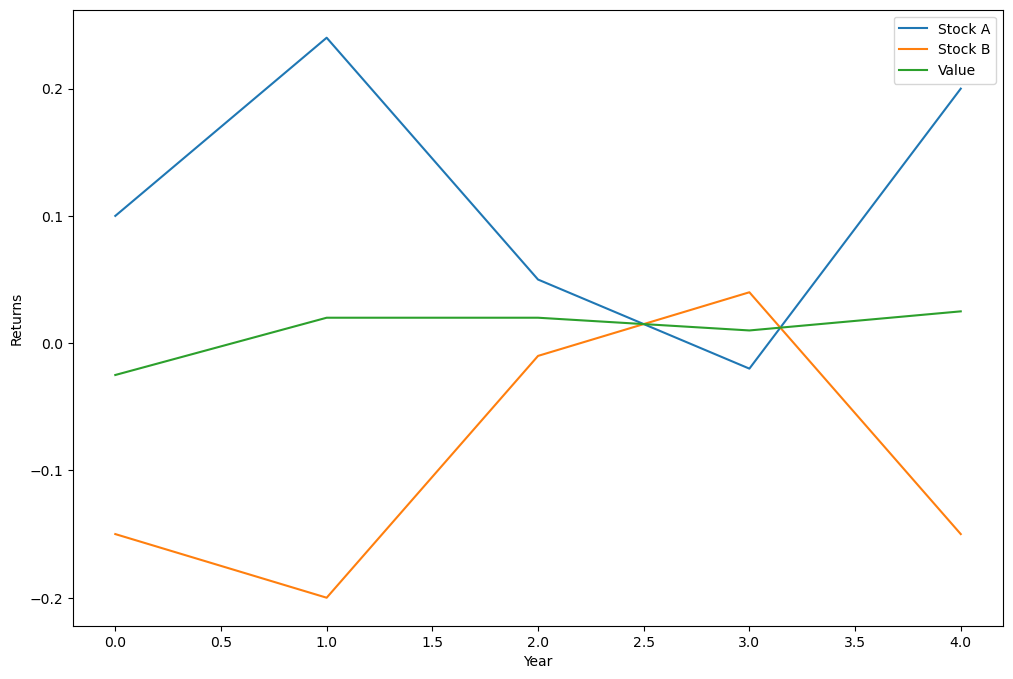

<Figure size 640x480 with 0 Axes>

In [21]:
plot_portfolio_returns(with_value)

In [23]:
returns.corr()

         Stock A  Stock B
Stock A    1.000   -0.926
Stock B   -0.926    1.000

# Computing an Efficient Portfolio

## Gathering historical returns from Yahoo! Finance

In [31]:
def get_historical_closes(ticker, start_date, end_date):
    # get the data for the tickers.  This will be a panel
    p = web.DataReader(ticker, "yahoo", start_date, end_date)    
    # convert the panel to a DataFrame and selection only Adj Close
    # while making all index levels columns
    d = p.to_frame()['Adj Close'].reset_index()
    # rename the columns
    d.rename(columns={'minor': 'Ticker', 
                      'Adj Close': 'Close'}, inplace=True)
    # pivot each ticker to a column
    pivoted = d.pivot(index='Date', columns='Ticker')
    # and drop the one level on the columns
    pivoted.columns = pivoted.columns.droplevel(0)
    return pivoted

In [33]:
import yfinance as yf
import pandas as pd

def get_historical_closes(tickers, start, end):
    """
    Fetch historical closing prices for a list of tickers.
    
    Parameters:
    tickers (list): List of ticker symbols
    start (str): Start date in 'YYYY-MM-DD' format
    end (str): End date in 'YYYY-MM-DD' format
    
    Returns:
    DataFrame: Historical closing prices for the tickers
    """
    data = yf.download(tickers, start=start, end=end)['Adj Close']
    return data

# Define the tickers and date range
tickers = ['MSFT', 'AAPL', 'KO']
start_date = '2010-01-01'
end_date = '2014-12-31'

# Fetch the historical closing prices
closes = get_historical_closes(tickers, start_date, end_date)

# Display the first few rows of the data
print(closes.head())

[*********************100%%**********************]  3 of 3 completed

Ticker       AAPL      KO    MSFT
Date                             
2010-01-04  6.462  18.210  23.389
2010-01-05  6.473  17.990  23.397
2010-01-06  6.370  17.983  23.253
2010-01-07  6.358  17.939  23.012
2010-01-08  6.401  17.607  23.170


In [35]:
closes[:5]

Ticker       AAPL      KO    MSFT
Date                             
2010-01-04  6.462  18.210  23.389
2010-01-05  6.473  17.990  23.397
2010-01-06  6.370  17.983  23.253
2010-01-07  6.358  17.939  23.012
2010-01-08  6.401  17.607  23.170

In [37]:
def calc_daily_returns(closes):
    return np.log(closes/closes.shift(1))

In [39]:
# calculate daily returns
daily_returns = calc_daily_returns(closes)
daily_returns[:5]

Ticker       AAPL         KO       MSFT
Date                                   
2010-01-04    NaN        NaN        NaN
2010-01-05  0.002 -1.217e-02  3.230e-04
2010-01-06 -0.016 -3.551e-04 -6.156e-03
2010-01-07 -0.002 -2.488e-03 -1.045e-02
2010-01-08  0.007 -1.868e-02  6.873e-03

In [41]:
# calculate annual returns
def calc_annual_returns(daily_returns):
    grouped = np.exp(daily_returns.groupby(
        lambda date: date.year).sum())-1
    return grouped

In [43]:
annual_returns = calc_annual_returns(daily_returns)
annual_returns

Ticker   AAPL     KO   MSFT
Date                       
2010    0.507  0.189 -0.079
2011    0.256  0.095 -0.045
2012    0.326  0.065  0.058
2013    0.081  0.172  0.443
2014    0.433  0.066  0.291

## Weighted variance co-variance calculation

In [46]:
def calc_portfolio_var(returns, weights=None):
    if weights is None: 
        weights = np.ones(returns.columns.size) / \
        returns.columns.size
    sigma = np.cov(returns.T,ddof=0)
    var = (weights * sigma * weights.T).sum()
    return var

In [48]:
# calculate our portfolio variance (equal weighted)
calc_portfolio_var(annual_returns)

0.003372591979994298

## The Sharpe Ratio

In [51]:
def sharpe_ratio(returns, weights = None, risk_free_rate = 0.015):
    n = returns.columns.size
    if weights is None: weights = np.ones(n)/n
    # get the portfolio variance
    var = calc_portfolio_var(returns, weights)
    # and the means of the stocks in the portfolio
    means = returns.mean()
    # and return the sharpe ratio
    return (means.dot(weights) - risk_free_rate)/np.sqrt(var)

In [53]:
# calculate equal weighted sharpe ratio
sharpe_ratio(annual_returns)

3.0225861488819414

## Optimization and minimization

In [56]:
# function to minimize
def y_f(x): return 2+x**2

In [60]:
import numpy as np
from scipy.optimize import fmin

# Define the function you want to minimize
def y_f(x):
    return (x - 3)**2 + 2

# Initial guess for the minimum
initial_guess = 1000

# Perform the minimization
result = fmin(y_f, initial_guess)

print("The minimum value is at:", result)

Optimization terminated successfully.
         Current function value: 2.000000
         Iterations: 27
         Function evaluations: 54
The minimum value is at: [2.9999733]


## Constructing an optimal portfolio 

In [63]:
def negative_sharpe_ratio_n_minus_1_stock(weights, 
                                          returns, 
                                          risk_free_rate):
    """
    Given n-1 weights, return a negative sharpe ratio
    """
    weights2 = sp.append(weights, 1-np.sum(weights))
    return -sharpe_ratio(returns, weights2, risk_free_rate)

In [65]:
def optimize_portfolio(returns, risk_free_rate):
    """ 
    Performs the optimization
    """
    # start with equal weights
    w0 = np.ones(returns.columns.size-1, 
                 dtype=float) * 1.0 / returns.columns.size
    # minimize the negative sharpe value
    w1 = scopt.fmin(negative_sharpe_ratio_n_minus_1_stock, 
                    w0, args=(returns, risk_free_rate))
    # build final set of weights
    final_w = sp.append(w1, 1 - np.sum(w1))
    # and calculate the final, optimized, sharpe ratio
    final_sharpe = sharpe_ratio(returns, final_w, risk_free_rate)
    return (final_w, final_sharpe)

In [71]:
import numpy as np
import pandas as pd
from scipy.optimize import fmin
from scipy import append as sp_append

def sharpe_ratio(returns, weights, risk_free_rate):
    """
    Calculate the Sharpe ratio for a portfolio.
    """
    portfolio_return = np.dot(returns.mean(), weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
    return (portfolio_return - risk_free_rate) / portfolio_volatility

def negative_sharpe_ratio_n_minus_1_stock(weights, returns, risk_free_rate):
    """
    Calculate the negative Sharpe ratio for a portfolio, excluding the last stock.
    """
    full_weights = np.append(weights, 1 - np.sum(weights))
    return -sharpe_ratio(returns, full_weights, risk_free_rate)

def optimize_portfolio(returns, risk_free_rate):
    """
    Perform portfolio optimization to maximize the Sharpe ratio.
    """
    # Start with equal weights
    w0 = np.ones(returns.shape[1] - 1, dtype=float) * 1.0 / (returns.shape[1])
    
    # Minimize the negative Sharpe ratio
    w1 = fmin(negative_sharpe_ratio_n_minus_1_stock, w0, args=(returns, risk_free_rate))
    
    # Build final set of weights
    final_w = sp_append(w1, 1 - np.sum(w1))
    
    # Calculate the final, optimized Sharpe ratio
    final_sharpe = sharpe_ratio(returns, final_w, risk_free_rate)
    
    return (final_w, final_sharpe)

# Example usage
# Create a DataFrame of returns
data = {
    'AAPL': np.random.normal(0.001, 0.02, 1000),
    'MSFT': np.random.normal(0.001, 0.02, 1000),
    'GOOG': np.random.normal(0.001, 0.02, 1000),
}
returns = pd.DataFrame(data)

# Assume a risk-free rate
risk_free_rate = 0.0001

# Optimize the portfolio
optimal_weights, optimal_sharpe = optimize_portfolio(returns, risk_free_rate)
print("Optimal weights:", optimal_weights)
print("Optimal Sharpe ratio:", optimal_sharpe)

Optimization terminated successfully.
         Current function value: -0.094229
         Iterations: 26
         Function evaluations: 48
Optimal weights: [0.24619469 0.50738632 0.24641899]
Optimal Sharpe ratio: 0.09422874317686614


/var/folders/dv/3stz4zmn5jn1dhpcpw10k25h0000gp/T/ipykernel_54237/2113354735.py:32: DeprecationWarning: scipy.append is deprecated and will be removed in SciPy 2.0.0, use numpy.append instead
  final_w = sp_append(w1, 1 - np.sum(w1))


# Visualizing the Efficient Frontier

In [74]:
def objfun(W, R, target_ret):
    stock_mean = np.mean(R,axis=0)
    port_mean = np.dot(W,stock_mean) # portfolio mean
    cov=np.cov(R.T) # var-cov matrix
    port_var = np.dot(np.dot(W,cov),W.T) # portfolio variance
    penalty = 2000*abs(port_mean-target_ret)# penalty 4 deviation
    return np.sqrt(port_var) + penalty # objective function

In [84]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Example objective function to minimize
def objfun(weights, returns, target_return):
    portfolio_return = np.dot(weights, returns.mean())
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
    return portfolio_volatility

def calc_efficient_frontier(returns):
    result_means = []
    result_stds = []
    result_weights = []
    
    means = returns.mean()
    min_mean, max_mean = means.min(), means.max()
    
    nstocks = returns.columns.size
    
    for r in np.linspace(min_mean, max_mean, 100):
        weights = np.ones(nstocks) / nstocks
        bounds = [(0, 1) for i in np.arange(nstocks)]
        constraints = [{'type': 'eq', 'fun': lambda W: np.sum(W) - 1},
                       {'type': 'eq', 'fun': lambda W: np.dot(W, returns.mean()) - r}]
        results = minimize(objfun, weights, args=(returns, r), 
                           method='SLSQP', constraints=constraints, bounds=bounds)
        if not results.success: # handle error
            raise Exception(results.message)
        result_means.append(np.round(r, 4)) # 4 decimal places
        std_ = np.round(np.sqrt(np.dot(results.x.T, np.dot(returns.cov(), results.x))), 6)
        result_stds.append(std_)
        
        result_weights.append(np.round(results.x, 5))
    return {'Means': result_means, 
            'Stds': result_stds, 
            'Weights': result_weights}

# Example usage
# Create a DataFrame of returns
data = {
    'AAPL': np.random.normal(0.12, 0.02, 1000),
    'MSFT': np.random.normal(0.10, 0.02, 1000),
    'GOOG': np.random.normal(0.15, 0.03, 1000)
}
returns = pd.DataFrame(data)

# Calculate the efficient frontier
efficient_frontier = calc_efficient_frontier(returns)

# Print the results
print("Efficient Frontier Means:", efficient_frontier['Means'][:5])
print("Efficient Frontier Stds:", efficient_frontier['Stds'][:5])
print("Efficient Frontier Weights:", efficient_frontier['Weights'][:5])

Efficient Frontier Means: [0.0995, 0.1, 0.1005, 0.101, 0.1015]
Efficient Frontier Stds: [0.019777, 0.019351, 0.018936, 0.018535, 0.018148]
Efficient Frontier Weights: [array([0., 1., 0.]), array([0.02432, 0.97568, 0.     ]), array([0.04865, 0.95135, 0.     ]), array([0.07297, 0.92703, 0.     ]), array([0.0973, 0.9027, 0.    ])]


In [86]:
# calculate our frontier
frontier_data = calc_efficient_frontier(annual_returns)

In [88]:
# first five risk levels
frontier_data['Stds'][:5]

[0.059293, 0.057201, 0.056284, 0.055399, 0.054549]

In [90]:
# first five mean returns
frontier_data['Means'][:5]

[0.1175, 0.1196, 0.1216, 0.1237, 0.1257]

In [92]:
# first five sets of optimal weights
frontier_data['Weights'][:5]

[array([0., 1., 0.]),
 array([0.006  , 0.94191, 0.0521 ]),
 array([0.01574, 0.92765, 0.05661]),
 array([0.02566, 0.91541, 0.05893]),
 array([0.03549, 0.90218, 0.06233])]

In [94]:
def plot_efficient_frontier(frontier_data):
    plt.figure(figsize=(12,8))
    plt.title('Efficient Frontier')
    plt.xlabel('Standard Deviation of the porfolio (Risk))')
    plt.ylabel('Return of the portfolio')
    plt.plot(frontier_data['Stds'], frontier_data['Means'], '--'); 
    plt.savefig('5104OS_09_20.png', bbox_inches='tight', dpi=300)

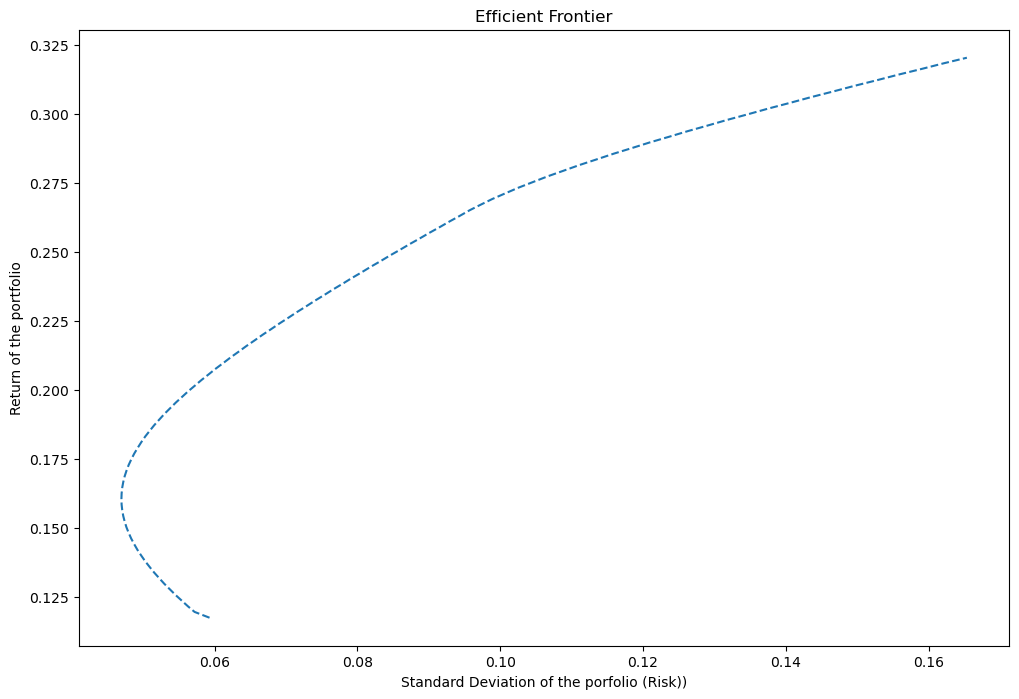

In [96]:
plot_efficient_frontier(frontier_data)

# Value At Risk

In [99]:
# get adjusted close values for AAPL in 2014
aapl_closes = get_historical_closes(['AAPL'], 
                                    datetime(2014, 1, 1),
                                    datetime(2014, 12, 31))
aapl_closes[:5]

[*********************100%%**********************]  1 of 1 completed


Date
2014-01-02    17.273
2014-01-03    16.894
2014-01-06    16.986
2014-01-07    16.864
2014-01-08    16.971
Name: Adj Close, dtype: float64

In [101]:
# now convert the daily prices to returns
returns = calc_daily_returns(aapl_closes)
returns[:5]

Date
2014-01-02      NaN
2014-01-03   -0.022
2014-01-06    0.005
2014-01-07   -0.007
2014-01-08    0.006
Name: Adj Close, dtype: float64

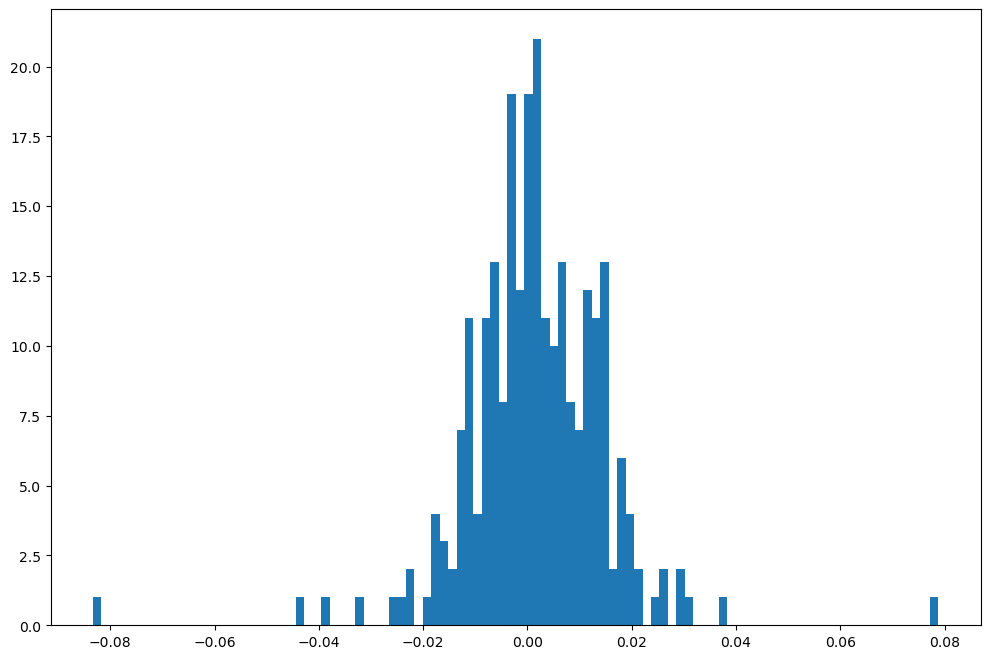

In [103]:
# plot the histogram of returns
plt.figure(figsize=(12,8))
plt.hist(returns.values[1:], bins=100);
plt.savefig('5104OS_09_23.png', bbox_inches='tight', dpi=300)

In [109]:
import scipy.stats as spstats

# Get the z-score for 95% confidence level
z = spstats.norm.ppf(0.95)
print(z)

1.6448536269514722


In [115]:
import yfinance as yf

# Fetch historical data for AAPL
aapl_data = yf.download('AAPL', start='2014-01-01', end='2015-01-01')

# Get the closing price on 2014-12-31
aapl_close_price = aapl_data.loc['2014-12-31', 'Adj Close']

# Calculate the position value
position = 1000 * aapl_close_price
position

[*********************100%%**********************]  1 of 1 completed


24636.52229309082

In [119]:
import yfinance as yf
import numpy as np

# Fetch historical data for AAPL
aapl_data = yf.download('AAPL', start='2010-01-01', end='2015-01-01')

# Calculate daily returns
returns = aapl_data['Adj Close'].pct_change().dropna()

# Get the closing price on 2014-12-31
aapl_close_price = aapl_data.loc['2014-12-31', 'Adj Close']

# Calculate the position value
position = 1000 * aapl_close_price

# Calculate the standard deviation of returns
std = returns.std()

# Get the z-score for 95% confidence level
z = spstats.norm.ppf(0.95)

# Calculate VaR
VaR = position * (z * std)
VaR

[*********************100%%**********************]  1 of 1 completed


680.1131768428887

# Misc

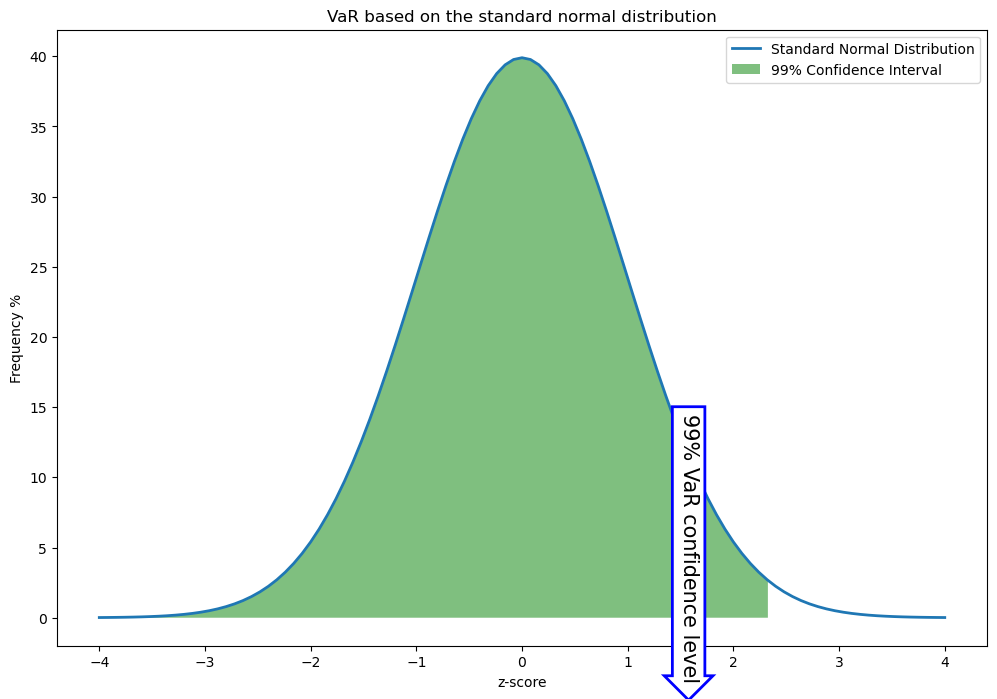

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the range for the x-axis and calculate the corresponding y-values for the normal distribution
x = np.linspace(-4, 4, 101)
y = norm.pdf(x) * 100

# Define the range for the shaded area (99% one-tail confidence interval)
z_score_99 = norm.ppf(0.99)
x2 = np.linspace(-4, z_score_99, 101)
y2 = norm.pdf(x2) * 100

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(x, y, linewidth=2, label='Standard Normal Distribution')

# Fill the area under the curve for the 99% confidence interval
plt.fill_between(x2, 0, y2, facecolor='g', alpha=0.5, label='99% Confidence Interval')

# Add labels and title
plt.xlabel('z-score')
plt.ylabel('Frequency %')
plt.title('VaR based on the standard normal distribution')

# Add text annotation for the confidence interval
bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="w", ec="b", lw=2)
plt.text(z_score_99 - 0.75, 5, "99% VaR confidence level", ha="center", va="center", 
         rotation=270, size=15, bbox=bbox_props)

# Add legend and show plot
plt.legend()
plt.savefig('5104OS_09_21.png', bbox_inches='tight', dpi=300)
plt.show()